In [1]:
# IMPORTS
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import irfft, rfft, rfftfreq
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
import pandas as pd
from scipy.special import wofz
from scipy.optimize import curve_fit
from scipy.signal import welch, get_window
%matplotlib widget 

from funcs_dsp import *
from funcs_df import load_df

In [ ]:
# Load dataframe and grab waveforms
laptop = True
dfs_to_load = ["Curated Data"] # If this is empty, all are loaded
df = load_df(laptop=laptop, dfs_to_load=dfs_to_load)
# Crop to only wf
df = df[df['wf'].notna()]
# Crop to only species
df_human = df[df['species'].isin(["Human"])]
df_lizard = df[df['species'].isin(["Lizard", "Anolis"])]


In [3]:
# Grab waveforms
h_idx = 0
l_idx = 0

wf_human = df_human.iloc[h_idx]['wf']
wf_lizard = df_lizard.iloc[l_idx]['wf']
sr_human = df_human.iloc[h_idx]['sr']
sr_lizard = df_lizard.iloc[l_idx]['sr']
if sr_human == sr_lizard:
    fs = sr_human
else:
    raise("Shouldn't these all have the same samplerate?")

In [ ]:
# Get PSDs and plot
plt.close('all')
# Parameters
scaling = "density"
detrend = None # No detrending
win_type = 'boxcar'
nperseg = 32768
zpad = 2
nfft = nperseg*zpad
log = False
f_min = 500 # Set minimum frequency for crop

f_human, psd_human = welch(wf_human, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=nfft, detrend=detrend)
f_lizard, psd_lizard = welch(wf_lizard, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=nfft, detrend=detrend)


if np.array_equal(f_human, f_lizard):
    f = f_human
else:
    raise("Why aren't these the same?")

f_min_idx = np.argmin(np.abs(f - f_min)) # Convert frequency to index
f_max_idx = f_min_idx + 4096*zpad

# Crop frequencies
f_cropped = f[f_min_idx:f_max_idx]
psd_lizard = psd_lizard[f_min_idx:f_max_idx]
psd_human = psd_human[f_min_idx:f_max_idx]



for psd, species in zip([psd_human, psd_lizard], ["Human", "Lizard"]):
    plt.figure(figsize=(10, 5))
    if scaling == 'spectrum':
        label = "Power Spectrum"
        ylabel = "PS"
    elif scaling == 'density':
        label = "Power Spectral Density"
        ylabel = "PSD"
        
    if log:
        # Convert to log
        psd = 10 * np.log10(psd)
        ylabel += " (Log)"
    else:
        ylabel += " (Linear)"
    
    if detrend == "constant":
        label += " (Detrended)"
    elif detrend == False:
        label += " (Not Detrended)"
        
    label+=f": nperseg={nperseg}"
    plt.title(f"{species} PSD (Cropped)")
    plt.plot(f_cropped, psd, label="Proposed Crop")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    

LORENTZIAN
f0 = 3707.92, y0 = 1.00e-10, amp = 34.19e-10, Gamma (HWHM) = 22.39
LORENTZIAN SMEARED
f0 = 3710.35, y0 = 2.40e-10, amp = -11.36e-10, Gamma (HWHM) = 0.77



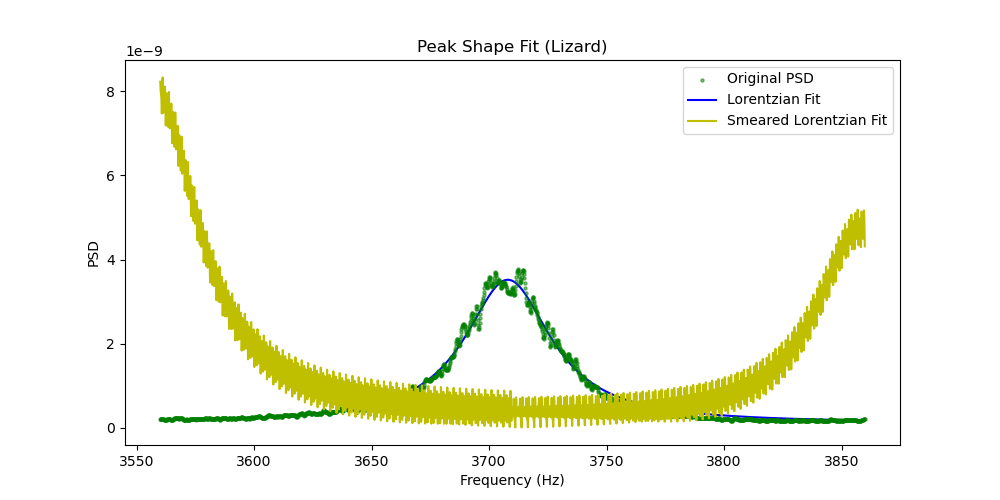

In [74]:
# Fitting functions
def Lorentz(x, x0, y0, amp, gamma):
    lorentzian = 1 / ((x - x0)**2 + gamma**2)
    return y0 + amp * lorentzian / lorentzian.max() # Normalize so max height = amp
def boxcar_FT(x, nperseg, fs):
    # With omega as normalized raidal freq and f as frequency, (omega / 2) in linked formula becomes (f * pi / fs)
    return np.sin((nperseg + 1)*(x)*np.pi/fs) / np.sin((x)*np.pi/fs) * np.exp(1j*nperseg*np.pi*x) 
def Lorentz_conv(x, x0, y0, amp, gamma):
    return np.abs(np.convolve(Lorentz(x, x0, y0, amp, gamma), boxcar_FT(x, nperseg, fs), mode='same'))

# Welch Parameters
scaling = "density"
detrend = None # No detrending
win_type = 'boxcar'
nperseg = 32768
zpad = 8
nfft = nperseg*zpad

f, psd_lizard = welch(wf_lizard, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=nfft, detrend=detrend)

# Fitting parameters
f_hw = 150 # Amount on either side to include
# Initial Guesses
f0 = 3710 # Peak center
y0 = 0 # Vertical shift
amp = 1e-9 # Peak max
gamma = 1 # FWHM of Lorentzian, or "amount" of Lorentzian in Voigt
sigma = 1 # Std of Gaussian, or "amount" of Gaussian in Voigt
# Functions
lorentz, lorentz_smeared = Lorentz, Lorentz_conv

# Calculate min and max freq idx to crop
f_min = f0 - f_hw
f_max = f0 + f_hw
f_min_idx = np.argmin(np.abs(f - f_min))
f_max_idx = np.argmin(np.abs(f - f_max))
x = f[f_min_idx:f_max_idx]
y = psd_lizard[f_min_idx:f_max_idx]

# Set bounds 
# (strangely, I have to let amp run negative to get a good fit on Lorentzian, though it always converges to positive.)
# Lorentzian_smeared actually throws an error if I don't let amp run negative, and it converges to negative for some reason.
bounds = (
    [f_min, 0, -1, 0], # f0, y0, amp, gamma
    [f_max, np.inf, np.inf, np.inf] 
)

# Set initial guess
p0 = [f0, y0, amp, gamma]



lorentz_params, lorentz_cov = curve_fit(lorentz, x, y, bounds=bounds, p0=p0)
lorentz_smeared_params, lorentz_smeared_cov = curve_fit(lorentz_smeared, x, y, bounds=bounds, p0=p0)

lorentz_fit = lorentz(x, *lorentz_params)
lorentz_smeared_fit = lorentz_smeared(x, *lorentz_params)

# Print fitting parameters

print("LORENTZIAN")
print(f"f0 = {lorentz_params[0]:.2f}, y0 = {lorentz_params[1]*10**10:.2f}e-10, amp = {lorentz_params[2]*10**10:.2f}e-10, Gamma (HWHM) = {lorentz_params[-1]:.2f}")
print("LORENTZIAN SMEARED")
print(f"f0 = {lorentz_smeared_params[0]:.2f}, y0 = {lorentz_smeared_params[1]*10**10:.2f}e-10, amp = {lorentz_smeared_params[2]*10**10:.2f}e-10, Gamma (HWHM) = {lorentz_smeared_params[-1]:.2f}")

print("")


ylabel = "PSD"
    
plt.close('all')
plt.figure(figsize=(10, 5))
plt.title(f"Peak Shape Fit")
if species is not None:
    plt.title(f"Peak Shape Fit ({species})")
plt.scatter(x, y, label="Original PSD", alpha=0.5, s=5, color='g', zorder=4)
plt.plot(x, lorentz_fit, label="Lorentzian Fit", color='b', zorder=2)
plt.plot(x, lorentz_smeared_fit, label="Smeared Lorentzian Fit", color='y', zorder=5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(ylabel)
plt.legend()
plt.show()

In [81]:
# Define profiles and fitting/plotting function
def Voigt(x, x0, y0, amp, gamma, sigma):
    z = ((x - x0) + 1j*gamma)/(sigma*np.sqrt(2))
    voigt_profile = np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))
    return y0 + amp * voigt_profile / voigt_profile.max() # Normalize so max height = amp

def Gauss(x, x0, y0, amp, sigma):
    return y0 + amp * np.exp(-(x - x0)**2 / (2 * sigma**2)) # Already true that max height = amp

def get_gauss_hwhm(sigma):
    return sigma*np.sqrt(2*np.log(2))

def get_voigt_hwhm(gamma, sigma):
    f_G = 2*get_gauss_hwhm(sigma)
    f_L = 2*gamma
    return (0.5346*f_L + np.sqrt(0.2166*f_L**2 + f_G**2))/2

def Lorentz(x, x0, y0, amp, gamma):
    lorentzian = gamma**2 / ((x - x0)**2 + gamma**2)
    return y0 + amp * lorentzian # Normalize so max height = amp

def boxcar_FT(x, nperseg, fs):
    def func(x):
        return (np.sin((nperseg + 1) * x * np.pi / fs) / np.sin((x) * np.pi / fs)) * np.exp(1j * nperseg * np.pi * x)
    if np.any(x == 0):
        center_idx = np.where(x == 0)[0][0]
        
        result = np.empty_like(x, dtype=complex)
        
        result[0:center_idx] = func(x[0:center_idx])
        result[center_idx + 1] = func(x[center_idx + 1])
        result[center_idx] = (nperseg + 1)
    else:
        result = func(x)
    return result / (nperseg + 1)

def Lorentz_conv(x, x0, y0, amp, gamma, nperseg, fs):
    """
    Compute the convolution of a Lorentzian peak with a boxcar function.
    
    Parameters:
        x (array): Positive half of FFT frequencies (starting from 0).
        x0 (float): Center of the Lorentzian peak.
        y0 (float): Offset of the Lorentzian peak.
        amp (float): Amplitude of the Lorentzian peak.
        gamma (float): Half-width at half-maximum (HWHM) of the Lorentzian peak.
        nperseg (int): Length of the boxcar function.
        fs (float): Sampling frequency.
    
    Returns:
        array: Convolution result corresponding to the original indices of x, with the peak preserved.
    """
    # Construct x_symm as the same length as x, centered around 0
    r = int(len(x) / 2)
    x_symm = np.linspace(-x[-r], x[-r], len(x))

    # Compute the Lorentzian function on the original x (positive frequencies)
    lorentz = Lorentz(x, x0, y0, amp, gamma)

    # Compute the boxcar function on the full frequency array
    boxcar = boxcar_FT(x_symm, nperseg, fs)

    # Perform the convolution with mode='same' to preserve the peak position
    result = np.convolve(lorentz, boxcar, mode='same')

    return np.abs(result)

def Dirichlet_mag(x, x0, y0, amp):
    return y0 + amp * np.abs(boxcar_FT(x - x0, nperseg, fs))

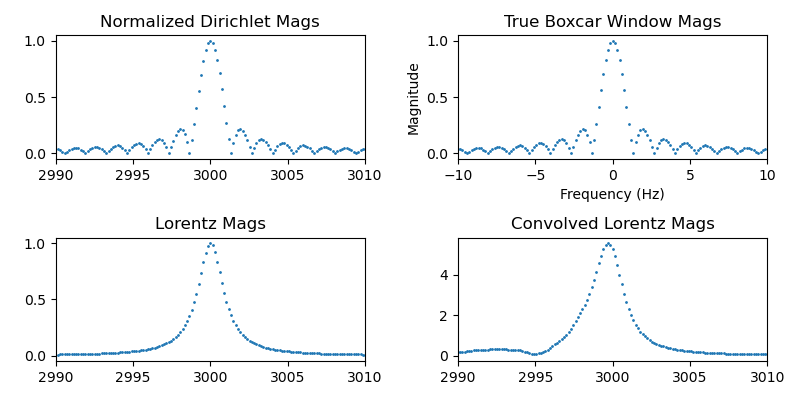

In [ ]:
# Double checking my dirichlet function
from scipy.signal.windows import get_window
from scipy.fft import fft, fftfreq
import numpy as np

def Lorentz(x, x0, y0, amp, gamma):
    lorentzian = gamma**2 / ((x - x0)**2 + gamma**2)
    return y0 + amp * lorentzian # Note max height = amp

def boxcar_FT(x, nperseg, fs):
    def func(x):
        return (np.sin((nperseg + 1) * x * np.pi / fs) / np.sin((x) * np.pi / fs)) * np.exp(1j * nperseg * np.pi * x)
    if np.any(x == 0):
        center_idx = np.where(x == 0)[0][0]
        
        result = np.empty_like(x, dtype=complex)
        
        result[0:center_idx] = func(x[0:center_idx])
        result[center_idx + 1] = func(x[center_idx + 1])
        result[center_idx] = (nperseg + 1)
    else:
        result = func(x)
    return result / (nperseg + 1)

def Lorentz_conv(x, x0, y0, amp, gamma, nperseg, fs):
    """
    Compute the convolution of a Lorentzian peak with a boxcar function.
    
    Parameters:
        x (array): Positive half of FFT frequencies (starting from 0).
        x0 (float): Center of the Lorentzian peak.
        y0 (float): Offset of the Lorentzian peak.
        amp (float): Amplitude of the Lorentzian peak.
        gamma (float): Half-width at half-maximum (HWHM) of the Lorentzian peak.
        nperseg (int): Length of the boxcar function.
        fs (float): Sampling frequency.
    
    Returns:
        array: Convolution result corresponding to the original indices of x, with the peak preserved.
    """
    # Construct x_symm as the same length as x, centered around 0
    r = int(len(x) / 2)
    x_symm = np.linspace(-x[-r], x[-r], len(x))

    # Compute the Lorentzian function on the original x (positive frequencies)
    lorentz = Lorentz(x, x0, y0, amp, gamma)

    # Compute the boxcar function on the full frequency array
    boxcar = boxcar_FT(x_symm, nperseg, fs)

    # Perform the convolution with mode='same' to preserve the peak position
    result = np.convolve(lorentz, boxcar, mode='same')
    # ALSO TRIED CIRCULAR CONVOLUTION, BUT PEAK WASN'T IN SAME PLACE AND LOOKED VERY STRANGE
    # result = np.real(np.fft.ifft( np.fft.fft(lorentz)*np.fft.fft(boxcar) ))

    return np.abs(result)

def Dirichlet_mag(x, x0, y0, amp):
    return y0 + amp * np.abs(boxcar_FT(x - x0, nperseg, fs))

# Parameters
nperseg = 32768
fs = 44100  # Sampling frequency
pad_factor = 8 # Zero-padding factor
pad_width = int(nperseg * pad_factor / 2)
N_padded = nperseg + pad_width * 2

# Generate the windows
boxcar_window = get_window('boxcar', nperseg)

# Zero-padding the windows (adding zeros on either side)
zero_padded_boxcar = np.pad(boxcar_window, pad_width)  # Pad with zeros to N_padded length

# Compute the Fourier Transform of the zero-padded windows
boxcar_ft = fft((zero_padded_boxcar))
boxcar_mags = np.abs(boxcar_ft) / (nperseg)
boxcar_phases = np.angle(boxcar_ft)



# Frequency axis (both positive and negative frequencies)
f_window = fftfreq(N_padded, 1/fs)  # Full frequency axis (both negative and positive)
f = fftfreq(N_padded, 1/fs)

# Plot the magnitude and phase of the Fourier Transforms
plt.figure(figsize=(8, 4))

width = 10

# Boxcar window - Magnitude
plt.subplot(2, 2, 2)
plt.scatter(f_window, boxcar_mags, s=1)
plt.title('True Boxcar Window Mags')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(-width, width)


x = f
freq = 3000
plt.subplot(2, 2, 1)
plt.scatter(x, Dirichlet_mag(x, freq, 0, 1), s=1)
plt.xlim(freq - width, freq + width)
plt.title("Normalized Dirichlet Mags")

plt.subplot(2, 2, 3)
plt.scatter(x, Lorentz(x, freq, 0, 1, 1), s=1)
plt.xlim(freq - width, freq + width)
plt.title("Lorentz Mags")

plt.subplot(2, 2, 4)
plt.scatter(x, Lorentz_conv(x, freq, 0, 1, gamma, nperseg, fs), s=1)
plt.xlim(freq - width, freq + width)
plt.title("Convolved Lorentz Mags")

plt.tight_layout()
plt.show()



In [ ]:
def fit_peak(x, y, f0, y0, amp, gamma, sigma, f_hw=100, log=False, species=None):
    voigt, lorentz, gauss, lorentz_smeared = Voigt, Lorentz, Gauss, Lorentz_conv
    # Calculate min and max freq idx to crop
    f_min = f0 - f_hw
    f_max = f0 + f_hw
    f_min_idx = np.argmin(np.abs(x - f_min))
    f_max_idx = np.argmin(np.abs(x - f_max))
    x = x[f_min_idx:f_max_idx]
    y = y[f_min_idx:f_max_idx]
    
    # Set bounds (strangely, I have to let amp run negative to get a good fit...)
    bounds = (
        [f_min, 0, -1, 0, 0], # f0, y0, amp, gamma, sigma
        [f_max, np.inf, np.inf, np.inf, np.inf] 
    )
    
    # Set initial guess
    p0 = [f0, y0, amp, gamma, sigma]
    
    # Crop bounds/p0 for gauss and lorentz dirichlete less params
    bounds_lorentz = (bounds[0][:4], bounds[1][:4])
    p0_lorentz = p0[0:4]
    bounds_gauss = (bounds[0][:3] + [bounds[0][4]], bounds[1][:3] + [bounds[1][4]])
    p0_gauss = p0[0:3] + p0[4:]
    # bounds_dirichlet = (bounds[0][:3], bounds[1][:3])
    # p0_dirichlet = p0[0:3]
    
    
    
    lorentz_params, lorentz_cov = curve_fit(lorentz, x, y, bounds=bounds_lorentz, p0=p0_lorentz)
    gauss_params, gauss_cov = curve_fit(gauss, x, y, bounds=bounds_gauss, p0=p0_gauss)
    voigt_params, voigt_cov = curve_fit(voigt, x, y, bounds=bounds, p0=p0)
    # dirichlet_params, dirichlet_cov = curve_fit(dirichlet_mag, x, y, bounds=bounds_dirichlet, p0=p0_dirichlet)
    lorentz_smeared_params, lorentz_smeared_cov = curve_fit(lorentz_smeared, x, y, bounds=bounds_lorentz, p0=p0_lorentz)

    lorentz_fit = lorentz(x, *lorentz_params)
    gauss_fit = gauss(x, *gauss_params)
    voigt_fit = voigt(x, *voigt_params)
    # dirichlet_fit = dirichlet_mag(x, *dirichlet_params)
    lorentz_smeared_fit = lorentz_smeared(x, *lorentz_params)

    print("")
    
    # Print MSE Details
    scale1e = -22
    best_mse = np.inf
    best_type = None

    for type, fit in zip(["Lorentzian", "Gaussian", "Voigt",  "Lorentz Smeared"], [lorentz_fit, gauss_fit, voigt_fit, lorentz_smeared_fit]):
        mse = np.mean((fit - y)**2)
        if best_mse > mse:
            best_mse = mse
            best_type = type
        
        print(f"MSE (1e{scale1e}) of {type} = {mse*(10**-scale1e):.2f}")
    
    print(f"Best Fit = {best_type}")
    
    print("")
    
    # Print fitting parameters
    
    print("LORENTZIAN")
    print(f"f0 = {lorentz_params[0]:.2f}, y0 = {lorentz_params[1]*10**10:.2f}e-10, amp = {lorentz_params[2]*10**10:.2f}e-10, Gamma (HWHM) = {lorentz_params[-1]:.2f}")
    print("LORENTZIAN SMEARED")
    print(f"f0 = {lorentz_smeared_params[0]:.2f}, y0 = {lorentz_smeared_params[1]*10**10:.2f}e-10, amp = {lorentz_smeared_params[2]*10**10:.2f}e-10, Gamma (HWHM) = {lorentz_smeared_params[-1]:.2f}")
    print("GAUSSIAN")
    print(f"f0 = {gauss_params[0]:.2f}, y0 = {gauss_params[1]*10**10:.2f}e-10, amp = {gauss_params[2]*10**10:.2f}e-10, Sigma = {gauss_params[-1]:.2f}, HWHM = {get_gauss_hwhm(gauss_params[-1]):.2f}")
    print(f"VOIGT")
    print(f"f0 = {voigt_params[0]:.2f}, y0 = {voigt_params[1]*10**10:.2f}e-10, amp = {voigt_params[2]*10**10:.2f}e-10, Gamma = {voigt_params[-2]:.2f}, Sigma = {voigt_params[-1]:.2f}, HWHM = {get_voigt_hwhm(voigt_params[-2], voigt_params[-1]):.2f}")
    # print(f"SINC")
    # print(f"f0 = {dirichlet_params[0]:.2f}, y0 = {dirichlet_params[1]*10**10:.2f}e-10, amp = {dirichlet_params[2]*10**10:.2f}e-10")
    
    print("")
    

    ylabel = "PSD"
    if log:
        y = 10*np.log10(y)
        ylabel = ylabel + " (Log)"
        
    plt.close('all')
    plt.figure(figsize=(10, 5))
    plt.title(f"Peak Shape Fit")
    if species is not None:
        plt.title(f"Peak Shape Fit ({species})")
    plt.scatter(x, y, label="Original PSD", alpha=0.5, s=5, color='g', zorder=4)
    plt.plot(x, voigt_fit, label="Voigt Fit", color='c', zorder=1)
    plt.plot(x, lorentz_fit, label="Lorentzian Fit", color='b', zorder=2)
    plt.plot(x, gauss_fit, label="Gaussian Fit", color='m', zorder=3)
    plt.plot(x, lorentz_smeared_fit, label="Smeared Lorentzian Fit", color='y', zorder=5)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
"Lizard Peak Shape Fitting"
x = f_cropped
y = psd_lizard
log = False # Log scale
f_hw = 150 # Amount on either side to include
# Initial Guesses
f0 = 3710 # Peak center
y0 = 0 # Vertical shift
amp = 1e-9 # Peak max
gamma = 1 # FWHM of Lorentzian, or "amount" of Lorentzian in Voigt
sigma = 1 # Std of Gaussian, or "amount" of Gaussian in Voigt

print("Lizard SOAE Peak Fitting")
fit_peak(x, y, f0, y0, amp, gamma, sigma, f_hw=f_hw, log=False, species=None)

In [ ]:
"Human Peak Shape Fitting"
species = "Human"
x = f_cropped
y = psd_human
log = False # Log scale
f_hw = 5 # Amount on either side to include
# Initial Guesses
f0 = 2252 # Peak center (4372, 2252)
y0 = 0 # Vertical shift
amp = 3e-7 # Peak max
gamma = 1 # FWHM of Lorentzian, or "amount" of Lorentzian in Voigt
sigma = 1 # Std of Gaussian, or "amount" of Gaussian in Voigt


fit_peak(x, y, f0, y0, amp, gamma, sigma, f_hw=f_hw, log=log, species=species)

In [ ]:
"Toy Voigt Fitting"
# Generate synthetic data with noise
np.random.seed(42)
x = np.linspace(2100, 2200, 2000)
x0, y0, amp, gamma, sigma = 2150, 0, 1, 1e-10, 1
y_true = Voigt(x, x0, y0, amp, gamma, sigma)
noise = np.random.normal(0, 0.05, x.size)
y = y_true + noise

p0 = (x0, y0, amp, gamma, sigma)
fitted_params, covariance = curve_fit(Voigt, x, y, p0=p0)

# Extract the fitted parameters
x0_fitted, y0_fitted, amp_fitted, sigma_fitted, gamma_fitted = fitted_params
print("Fitted Parameters:")
print(f"x0: {x0_fitted:.3f}, y0: {y0_fitted:.3f}, Amplitude: {amp_fitted:.3f}, Sigma: {sigma_fitted:.3f}, Gamma: {gamma_fitted:.3f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b.', label='Data')
plt.plot(x, y_true, 'k--', label='True Voigt Profile', zorder=2)
plt.plot(x, Voigt(x, *fitted_params), 'r-', label='Fitted Voigt Profile', zorder=1)
# plt.plot(x, Gauss(x, x0, y0, amp, sigma), label="Gaussian")
# plt.plot(x, Lorentz(x, x0, y0, amp, gamma), label="Lorentz")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Nonlinear Curve Fitting for a Voigt Distribution")
plt.show()
